- Harris: apply gaussian, compute the matrix M (gradient), compute the Harris and that's all, that's easy

In [1]:
from pathlib import Path
import numpy as np
from numpy.linalg import det
import matplotlib.pyplot as plt
from PIL import Image

from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
import cv2

import gzip 
import sys
import pickle

In [2]:
data_dir = Path("./rubiks_cube_photos")

In [30]:
def load_data():
    # Loop over all the files in the data directory
    data = []
    for file in list(data_dir.rglob("*.jpg")) + list(data_dir.rglob("*.JPG")):
        # Load the image
        img = Image.open(file).convert("L")
        # Resize to 128x128
        img = img.resize((128, 128))
        # Convert to numpy array
        img = np.array(img)
        # Append to the list of images
        data.append(img)
    return data

In [31]:
Gx_filter = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])

Gy_filter = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

def harris_detection(image):
    img_sigma = 1
    der_sigma = 0.6
    threshold = 0.01
    filtered_image = gaussian_filter(image, sigma=img_sigma)
    Ix = convolve2d(filtered_image, Gx_filter, mode='same')
    Iy = convolve2d(filtered_image, Gy_filter, mode='same')
    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy
    Ixx = gaussian_filter(Ixx, sigma=der_sigma)
    Iyy = gaussian_filter(Iyy, sigma=der_sigma)
    Ixy = gaussian_filter(Ixy, sigma=der_sigma)
    det = Ixx*Iyy - Ixy**2
    trace = Ixx + Iyy
    R = det - 0.04*trace**2

    xx, yy = np.where(R > threshold*R.max())
    R = np.where(R > 0.01*R.max(), R, 0)

    for x, y in zip(xx, yy):
        if x < 5 or y < 5 or x > R.shape[0]-5 or y > R.shape[1]-5:
            R[x,y] = 0
            continue
        values = R[x-5:x+5,y-5:y+5]
        R[x-5:x+5,y-5:y+5] = np.where(values == values.max(), values, 0)

    return R

In [32]:
data = load_data()

In [33]:
len(data)

48

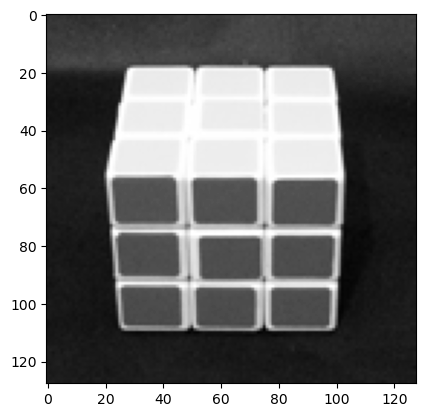

In [46]:
img = data[15]

plt.imshow(img, cmap='gray')

In [47]:
m = harris_detection(img)

In [48]:
len(np.where(m > 0)[0])

20

In [49]:
plot_image = np.expand_dims(img, 2).repeat(3, 2)

In [50]:
for x, y in zip(*np.where(m > 0.01*m.max())):
    cv2.circle(plot_image,(y, x), int(0.01*max(plot_image.shape)), (255,0,0), -1)

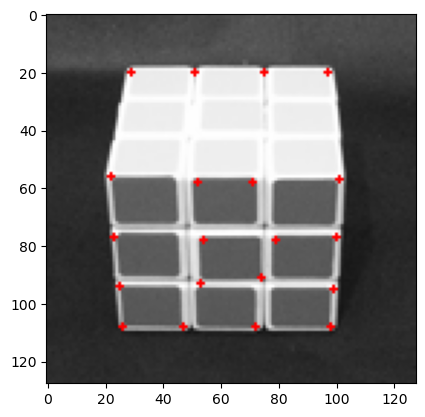

In [51]:
plt.imshow(plot_image)

In [52]:
def compute_gradients(image):    
    # Compute the x and y gradients using the Sobel operator
    grad_x = convolve2d(image, Gx_filter, mode='same')
    grad_y = convolve2d(image, Gy_filter, mode='same')
    
    # Compute gradient magnitude and direction (in degrees)
    magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
    orientation = np.arctan2(grad_y, grad_x) * (180 / np.pi)
    orientation = np.mod(orientation, 360)  # Map orientations to 0-360 degrees
    
    return magnitude, orientation

def orientation_binning(magnitude, orientation, cell_size, num_bins=4):
    # Initialize the bins for the entire image
    bin_edges = np.linspace(0, 360, num_bins+1, endpoint=True)
    cell_rows, cell_cols = magnitude.shape[0] // cell_size[0], magnitude.shape[1] // cell_size[1]
    hog_vector = np.zeros((cell_rows, cell_cols, num_bins))
    
    # Process each cell
    for i in range(cell_rows):
        for j in range(cell_cols):
            cell_magnitude = magnitude[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            cell_orientation = orientation[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            
            # Bin the orientations within the cell
            for b in range(num_bins):
                bin_mask = (cell_orientation >= bin_edges[b]) & (cell_orientation < bin_edges[b+1])
                hog_vector[i, j, b] = np.sum(cell_magnitude[bin_mask])
    
    # Flatten the HOG vector for the entire image
    hog_vector = hog_vector.ravel()
    
    # Normalize the histogram
    norm = np.linalg.norm(hog_vector)
    if norm != 0:
        hog_vector /= norm
    
    return hog_vector

def hog_descriptor(image, cell_size=(8, 8), num_bins=4):
    magnitude, orientation = compute_gradients(image)
    hog_vector = orientation_binning(magnitude, orientation, cell_size, num_bins)
    return hog_vector

In [53]:
hog_features = hog_descriptor(img, cell_size=(8, 8), num_bins=4)

In [54]:
hog_features.shape

(1024,)